## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

## ナイル川流量データ

In [7]:
os.makedirs("./data",exist_ok=True)
urlretrieve("https://raw.githubusercontent.com/statsmodels/statsmodels/master/statsmodels/datasets/nile/nile.csv",
           "./data/nile.csv")

('./data/nile.csv', <http.client.HTTPMessage at 0x7f37cbf33880>)

In [39]:
df=pd.read_csv("./data/nile.csv").iloc[:20]

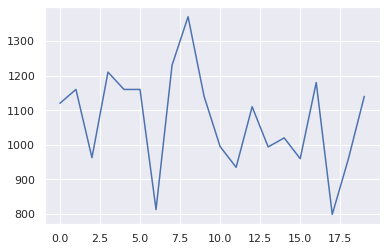

In [40]:
df["volume"].plot();

## ローカルレベルモデル

In [41]:
N=len(df)
Y=df["volume"].values
with pm.Model() as model:
    mu=[0]*N
    y=[0]*N
    
    mu_std=pm.Uniform("mu_std",0,10000)
    y_std=pm.Uniform("y_std",0,10000)
    mu[0]=pm.Normal("mu_0",mu=1150,sd=mu_std)
    for i in range(1,N):
        mu[i]=pm.Normal(f"mu_{i}",mu=mu[i-1],sd=mu_std)
    for i in range(N):
        y[i]=pm.Normal(f"obs_{i}",mu=mu[i],sd=y_std,observed=Y[i])

In [42]:
with model:
    step=pm.Metropolis()
    trace=pm.sample(10000,step=step,return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [mu_19]
INFO:pymc3:>Metropolis: [mu_19]
>Metropolis: [mu_18]
INFO:pymc3:>Metropolis: [mu_18]
>Metropolis: [mu_17]
INFO:pymc3:>Metropolis: [mu_17]
>Metropolis: [mu_16]
INFO:pymc3:>Metropolis: [mu_16]
>Metropolis: [mu_15]
INFO:pymc3:>Metropolis: [mu_15]
>Metropolis: [mu_14]
INFO:pymc3:>Metropolis: [mu_14]
>Metropolis: [mu_13]
INFO:pymc3:>Metropolis: [mu_13]
>Metropolis: [mu_12]
INFO:pymc3:>Metropolis: [mu_12]
>Metropolis: [mu_11]
INFO:pymc3:>Metropolis: [mu_11]
>Metropolis: [mu_10]
INFO:pymc3:>Metropolis: [mu_10]
>Metropolis: [mu_9]
INFO:pymc3:>Metropolis: [mu_9]
>Metropolis: [mu_8]
INFO:pymc3:>Metropolis: [mu_8]
>Metropolis: [mu_7]
INFO:pymc3:>Metropolis: [mu_7]
>Metropolis: [mu_6]
INFO:pymc3:>Metropolis: [mu_6]
>Metropolis: [mu_5]
INFO:pymc3:>Metropolis: [mu_5]
>Metropolis: [mu_4]
INFO:pymc3:>Metropolis: [mu_4]
>Metropolis: [mu_3]
INFO:pymc3

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 61 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [43]:
mu_samples = np.array([trace['mu_'+str(i)] for i in range(N)])
pred=mu_samples.mean(axis=1)

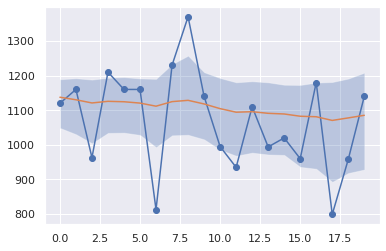

In [48]:
plt.plot(Y,marker="o")
plt.plot(pred)
mu_lower, mu_upper = np.percentile(mu_samples, q=[2.5, 97.5], axis=1)
plt.fill_between(list(range(N)), mu_lower, mu_upper, alpha=0.3)